# Classifying Computer Screenshots

The goal in this work is to redesign a <b>supervised computer screen classifier</b> I developed in 2017 as a part of my PhD thesis (For more, see chapters 4 and 5 here: https://ruor.uottawa.ca/handle/10393/36272). 

Classification is often cast as a solved problem, where you only need more data to resolve any type of problem. This is, of course, the wrong way to think about classification. Instead, classification is a journey of exploration, following the data wherever it leads, until, hopefully, you land on an acceptable solution. Often the answer is to collect more data, rather than wandering the ML landscape, hoping for a miracle. But sometimes, as we will see here, it is very worthwhile spending a few days trying lots of stuff.

The approaches explored in this work may be interesting to machine learning practitioners, mostly because of all of the approaches that did not work, and the use of a proprietary dataset. It may be interesting for you to see the application of machine learning on a proprietary dataset. The problem itself comes from wrestling with the data and models to try and force some learning to generalize to unseen data. Computer screens are big and noisy, and so classifying what is happening on them is an interesting problem.

<b>Summary</b>

For you TL;DR people, here are the approaches and results you will encounter below (skipping boring stuff):

- ❌ Failed on Google Collab so moved to Titan V on-premise
- ✅ Look at the data. Check for dataset class imbalance and use our eyes to understand the data.
- ❌ Failed trying a basic CNN model (fails to generalize)
- ❌ Failed after adding data augmentation (horizontal flip is the only one that didn't make things worse - model still fails to generalize)
- ❌ Failed transfer learning from InceptionV3, even with class weights enabled. Model didn't generalize. I could have tried other networks like VGG19, etc, but decided to move on to other approaches.
- ✅ First success with a 'normal' ML approach a pipeline with PCA and SVM. Results MEH but at least it learned something
- ✅ Moved on to AutoML with TPOT to see if it can make a better ML pipeline than my PCA+SVM approach. It crushed it. Did amazing.
- ❌ Failed to get mlblocks to run. Config issues. Moved on.
- ✅ Also found success with a pretraining step. Started with an autoencoder and then retrained the encoder as a classifier. Worked like a charm

The original classifier from my thesis was a convolutional neural network, and in the remainder of this notebook I will go through a variety of approaches solve the problem, and perhaps to improve on my original results. In this work I restricted the categories I'm working on to those for which I had more data (between 600 and 3000 labelled images per category for 5 categories of screenshot). The data is messy. Some screenshots are of a window, or a program, or the whole screen. 

This screenshot classification model is a subcomponent of a larger project to help computer users work with the computer to do stuff. To set the scene, the following is the <b>thesis abstract</b>: <i>"A new way to train a virtual assistant with unsupervised learning is presented in this thesis. Rather than integrating with a particular set of programs and interfaces, this new approach involves shallow integration between the virtual assistant and computer through machine vision. In effect the assistant interprets the computer screen in order to produce helpful recommendations to assist the computer user. In developing this new approach, called AVRA, the following methods are described: an unsupervised learning algorithm which enables the system to watch and learn from user behavior, a method for fast filtering of the text displayed on the computer screen, a deep learning classifier used to recognize key onscreen text in the presence of OCR translation errors, and a recommendation filtering algorithm to triage the many possible action recommendations. AVRA is compared to a similar commercial state-of-the-art system, to highlight how this work adds to the state of the art. AVRA is a deep learning image processing and recommender system that can collaborate with the computer user to accomplish various tasks. This document presents a comprehensive overview of the development and possible applications of this novel virtual assistant technology. It detects onscreen tasks based upon the context it perceives by analyzing successive computer screen images with neural networks. AVRA is a recommender system, as it assists the user by producing action recommendations regarding onscreen tasks. In order to simplify the interaction between the user and AVRA, the system was designed to only produce action recommendations that can be accepted with a single mouse click. These action recommendations are produced without integration into each individual application executing on the computer. Furthermore, the action recommendations are personalized to the user’s interests utilizing a history of the user’s interaction."</i>

## Let's use google collab

Let's set the path:

<b>PATH = "/content/gdrive/My Drive/Colab Notebooks/data/avra/"</b>

Let's upload the 1GB of images and mount google drive to the notebook

<b>from google.colab import drive
drive.mount('/content/gdrive')</b>

... Nope. Disk access is too slow, and the GPU libraries are not the same setup as standard NVIDIA images

## Let's use an on-premise Titan V instead

Upload files to server. Unzip. Move files to a nice location. Keep moving.

### Set path to images directory and identify broken images

In [1]:
PATH = "/home/lemay/daniel/thesis_redo/"
PATH

'/home/lemay/daniel/thesis_redo/'

The following code opens up each image to make sure there are no broken images. Many images are dropped from the dataset during this step. The flag "test" specifies if we should re-run this testing and data cleanup script when we rerun all the cells in the notebook. After it runs the first time, the result is always that the dataset is fine, and so after running it once it can be skipped. 

In [192]:
# Sources: https://opensource.com/article/17/2/python-tricks-artists
# See also: https://stackoverflow.com/questions/46232981/userwarning-possibly-corrupt-exif-data-while-classifying-images
# See also: https://github.com/python-pillow/Pillow/issues/3352
import glob
from PIL import Image
from tqdm import tqdm_notebook as tqdm

test=False
if test:
    total=0
    broken=0
    for filename in tqdm(glob.glob(PATH+"*/*/*.jpg")):
        try:
            total+=1
            img = Image.open(filename) # open the image file
            img.verify() # verify that it is, in fact an image
            exif_data = img._getexif()
        except (IOError, SyntaxError, ValueError,AttributeError,UserWarning) as e:
            broken+=1
            print('Bad file:', filename) # print out the names of corrupt files
            !rm {filename.replace(" ","\ ")}
    print(broken/total,broken,total)

## Import Packages

In [208]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

# This next part is actually important, and the machine learning will not work on the dataset without it
# Source: https://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Load data

This part of the notebook is based upon a Tensorflow <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb" target="_blank">Google Collab tutorial on classifying cat and dog images</a>. 

Their dataset had the following directory structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

Our dataset has this identical directory structure:

<pre>
<b>PATH</b>
|__ <b>train</b>
    |______ <b>console</b>: [...]
    |______ <b>gene</b>: [...]
    ...
|__ <b>validation</b>
    |______ <b>console</b>: [...]
    |______ <b>gene</b>: [...]
    ...
</pre>

In [209]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

categories=os.listdir(train_dir)
# directories with our training pictures
train_dirs= [os.path.join(train_dir, cat) for cat in categories]  
# directories with our validation pictures
validation_dirs = [os.path.join(validation_dir, cat) for cat in categories]  
train_dirs,validation_dirs

(['/home/lemay/daniel/thesis_redo/train/console',
  '/home/lemay/daniel/thesis_redo/train/gene',
  '/home/lemay/daniel/thesis_redo/train/eclipse',
  '/home/lemay/daniel/thesis_redo/train/facebook',
  '/home/lemay/daniel/thesis_redo/train/legal'],
 ['/home/lemay/daniel/thesis_redo/validation/console',
  '/home/lemay/daniel/thesis_redo/validation/gene',
  '/home/lemay/daniel/thesis_redo/validation/eclipse',
  '/home/lemay/daniel/thesis_redo/validation/facebook',
  '/home/lemay/daniel/thesis_redo/validation/legal'])

## Understand the data. Look at the data with our eyes.

In [210]:
# count the number of training (num_tr) and validation images (num_val) in each folder
num_tr =  [len(os.listdir(aDir)) for aDir in train_dirs]
num_val = [len(os.listdir(aDir)) for aDir in validation_dirs]

# count the total number of training and validation images
total_train = sum(num_tr)
total_val = sum(num_val)
print("{} training images, and {} validation images on {} categories"
      .format(total_train,total_val,len(num_tr)))

7105 training images, and 50 validation images on 5 categories


### Check for dataset imbalance

In [211]:
from collections import Counter
counts={}
for cat in train_dirs:
    clss=cat.split("/")[-1]
    count=len(os.listdir(cat))
    print('{} total training images: {}'.format(clss, count))
    counts[clss]=count

# Source: https://github.com/keras-team/keras/issues/1875
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}    

class_weights=get_class_weights(counts)
class_weights

console total training images: 638
gene total training images: 970
eclipse total training images: 1679
facebook total training images: 882
legal total training images: 2936


{'console': 4.601880877742946,
 'gene': 3.02680412371134,
 'eclipse': 1.748659916617034,
 'facebook': 3.328798185941043,
 'legal': 1.0}

Let's check our work. The console class is the smallest class (638 training samples), and it got the highest weight (4.6). The legal class is the biggest (2936 training samples), and it got the lowest weight (1.0). <a href="https://www.dictionary.com/e/acronyms/lgtm/" target="_blank">LGTM</a>.

### Set parameters for pre-processing the dataset and training the network.

Note: I did a lot of fiddling with the image sizes to find which sizes are too small for me to do the tasks of classifying image screenshots. The intuition is that you want to downsample the data, but not so much that the differentiating features disappear.

In [212]:
batch_size = 32
epochs = 15
IMG_HEIGHT = 128
IMG_WIDTH = 128

### Data preparation

Source: https://www.tensorflow.org/tutorials/images/classification

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Use `ImageDataGenerator` in `tf.keras` to read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network. After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [214]:
# Generator for our training data
train_image_generator = ImageDataGenerator(rescale=1./255) 
# Generator for our validation data
validation_image_generator = ImageDataGenerator(rescale=1./255) 
# Create the training data generator
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 7105 images belonging to 5 classes.


In [215]:
# Create the validation data generator
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 50 images belonging to 5 classes.


### Visualize the image data

Source: https://www.tensorflow.org/tutorials/images/classification

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`. The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

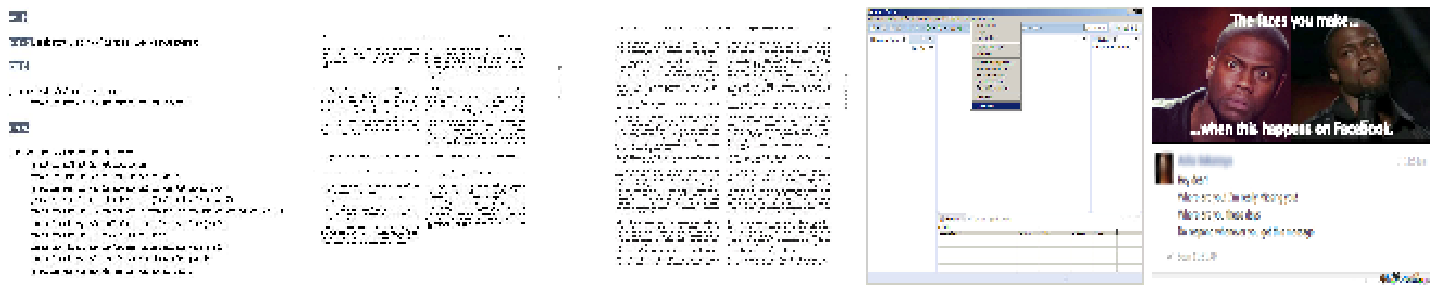

In [216]:
sample_training_images, _ = next(train_data_gen)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:5])

We can see in this data preview that the data is pretty hard to make out. For example, screenshots of facebook, the Eclipse IDE, and a black terminal console are to me, a human, pretty easy to tell apart, but the difference between a research paper on genetics (the gene class) and legal documents (the legal class) are hard to tell apart. I made a point ot browse the images in Windows file explorer, to become more familiar with the images in the dataset.

In [ ]:
# Source: https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure

matplotlib.rcParams['font.size'] = 8

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

for _ in tqdm(range(5)):
    print("=============")
    data=next(val_data_gen)
    # Load an example image
    img = data[0][0]
    print(img.shape)
    from PIL import Image
    im = Image.fromarray(np.uint8(cm.gist_earth(img)*255))
    
    print(im.histogram().shape)
    print("LABEL==",np.argmax(data[1][0]))
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

    # Equalization
    img_eq = exposure.equalize_hist(img)

    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

    # Display results
    fig = plt.figure(figsize=(8, 5))
    axes = np.zeros((2, 4), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 4, 1)
    for i in range(1, 4):
        axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 4):
        axes[1, i] = fig.add_subplot(2, 4, 5+i)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
    ax_img.set_title('Contrast stretching')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
    ax_img.set_title('Histogram equalization')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
    ax_img.set_title('Adaptive equalization')

    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()

## Create compile and summarize a convolutional NN model from random weights

Source: https://www.tensorflow.org/tutorials/images/classification

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function. The Tensorflow tutorial chose the *ADAM* optimizer and *binary cross entropy* loss function.

In [217]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

### Train the CNN model, and see what goes wrong

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [40]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

W0419 23:15:11.274147 140288296396544 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0419 23:15:11.584211 140288296396544 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 55 steps, validate for 1 steps
Epoch 1/15
55/55 [==============================] - 85s 2s/step - loss: 8.0087 - accuracy: 0.0897 - val_loss: 9.6709 - val_accuracy: 0.2000
Epoch 2/15
55/55 [==============================] - 84s 2s/step - loss: 8.0064 - accuracy: 0.0894 - val_loss: 9.6709 - val_accuracy: 0.2000
Epoch 3/15
55/55 [==============================] - 84s 2s/step - loss: 8.0179 - accuracy: 0.0902 - val_loss: 9.6709 - val_accuracy: 0.2000
Epoch 4/15
55/55 [==============================] - 84s 2s/step - loss: 8.0179 - accuracy: 0.0897 - val_loss: 9.6709 - val_accuracy: 0.2000
Epoch 5/15
55/55 [==============================] - 84s 2s/step - loss: 8.0019 - accuracy: 0.0900 - val_loss: 9.6709 - val_accuracy: 0.2000
Epoch 6/15
55/55 [==============================] - 84s 2s/step - loss: 8.0064 - accuracy: 0.0892 - val_loss: 9.6709 - val_accuracy: 0.2000
Epoch 7/15
55/55 [==============================] - 84s 2s/step - loss: 8.0270 - accuracy: 0.0892 - val_loss: 9.6709 - 

KeyboardInterrupt: 

The model fails to learn. The next step is to see if overfitting is the problem. In the original Tensorflow tutorial on classifying cats vs dogs, training accuracy and validation accuracy were off by large margin and the model achieved only around **70%** accuracy on the validation set. <i>"When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset."</i> They moved on to look at <b>data augmentation</b> and <b>dropout</b>, and so will we. Keep in mind that with five balanced classes in our validation dataset, a 20% validation score is random chance. A bit less or more than 20% is just luck.

## Apply data augmentation, and retrain a CNN

I found that applying transformations like rotation are a bad idea. screenshot angles don't change, and so it is harder to learn when this augmentation is added. zoom and other augmentations also didn't help, and so the only transformation I kept was horizontal flip. Ironically, I ended up in the same place for my thesis work. 

Generally, you only apply data augmentation to the training examples. In this case, only flip the validation images and convert them into batches using `ImageDataGenerator`. The validation data is unaltered.

### Add image flips

In [218]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.75) # 

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 7105 images belonging to 5 classes.


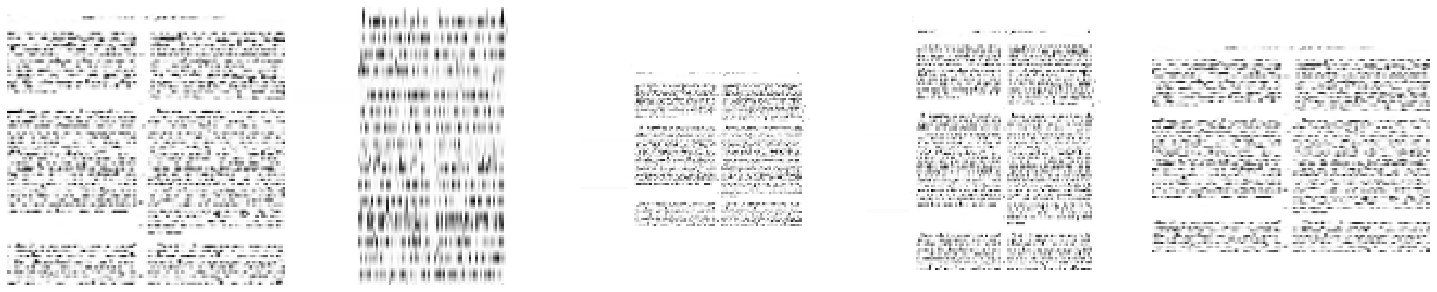

In [219]:
plotImages(augmented_images)

The images above show you what the zoom_range augmentation does to the images, and so I'm not surprised it didn't help the model learn about this beer goggles effect particular classification problem. Some datasets do benefit from this approach, and so it's not a one-size-fits-all world.

In [224]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    #rotation_range=45,
                    #width_shift_range=.15,
                    #height_shift_range=.15,
                    horizontal_flip=True,
                    #zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

Found 7105 images belonging to 5 classes.


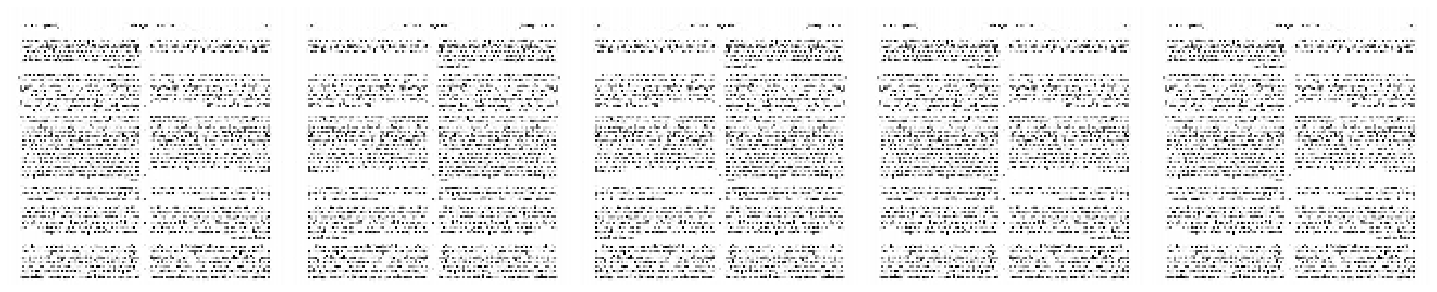

In [225]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [227]:
# Here we put the validation data generator. It does the scaling and yielding bit of the job
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

Found 50 images belonging to 5 classes.


### Add dropout to the model

Source: https://www.tensorflow.org/tutorials/images/classification

When you apply dropout *regularization* to a layer it randomly drops out (sets to zero) a number of output units from the applied layer during the training process. Here, you apply dropout to first and last max pool layers. Applying dropout will randomly set 20% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset.

You can see in the cell below that I did a lot of messing with the architecture and parameters to try and get the model to learn.

In [229]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    #Dropout(0.2),
    Flatten(),
#     Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5)
])
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 256)       37120     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 256)      

### Train the new CNN model and see what went wrong

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [24]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

W0420 01:31:02.857608 140281110439680 deprecation.py:323] From <ipython-input-24-2401ab36538a>:6: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.
W0420 01:31:03.246812 140281110439680 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0420 01:31:03.491335 140281110439680 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 222 steps, validate for 1 steps
Epoch 1/15
 71/222 [========>.....................] - ETA: 1:32 - loss: 1.6407 - accuracy: 0.0612

/home/lemay/py_36_env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


222/222 [==============================] - 134s 606ms/step - loss: 5.2851 - accuracy: 0.1924 - val_loss: 9.0664 - val_accuracy: 0.1875
Epoch 2/15
222/222 [==============================] - 134s 602ms/step - loss: 8.9703 - accuracy: 0.3913 - val_loss: 9.5701 - val_accuracy: 0.1875
Epoch 3/15
222/222 [==============================] - 134s 602ms/step - loss: 7.1625 - accuracy: 0.3817 - val_loss: 7.0531 - val_accuracy: 0.1875
Epoch 4/15
222/222 [==============================] - 134s 602ms/step - loss: 7.0049 - accuracy: 0.3819 - val_loss: 7.0517 - val_accuracy: 0.1875
Epoch 5/15
222/222 [==============================] - 134s 602ms/step - loss: 4.2285 - accuracy: 0.3308 - val_loss: 7.0517 - val_accuracy: 0.1875
Epoch 6/15
222/222 [==============================] - 134s 602ms/step - loss: 4.4773 - accuracy: 0.3303 - val_loss: 7.0517 - val_accuracy: 0.1875
Epoch 7/15
222/222 [==============================] - 133s 601ms/step - loss: 4.5222 - accuracy: 0.3272 - val_loss: 7.0517 - val_accura

KeyboardInterrupt: 

### What went wrong?

We can see that an off-the-shelf approach that worked for one dataset is stubbornly not working for a different dataset. This is really common and very frustrating. Let's move on to another approach, called transfer learning.

## A transfer learning approach

Maybe it is hard to learn the features that make screenshots distictive when starting from scratch with a ranomly initialized neural network (<a href="https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79" target="_blank">interesting side note</a>), and a pretrained CNN like VGG19, inception, or some other network has already learned these features when it was trained on a massive dataset of images. In this approach let's use an example from Keras for how to do transfer learning on InceptionV3.

There are 2 training phases. First just a last layer is trained, and then the last few blocks of Inception are trained. What we see is the training and validation curves don't match. See `loss` and `val_loss` below, and use your imagination a bit. The training loss goes down, but the validation loss does poorly in the first training phase and even worse in the second training phase.

In [26]:
# Source: https://keras.io/applications/
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(5, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
 94/222 [===========>..................] - ETA: 1:33 - loss: 1.2584

/home/lemay/py_36_env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


222/222 [==============================] - 162s 728ms/step - loss: 0.9222 - val_loss: 1.5259
Epoch 2/15
222/222 [==============================] - 160s 721ms/step - loss: 0.5384 - val_loss: 1.7889
Epoch 3/15
222/222 [==============================] - 160s 723ms/step - loss: 0.4711 - val_loss: 1.7303
Epoch 4/15
222/222 [==============================] - 160s 721ms/step - loss: 0.4272 - val_loss: 2.4765
Epoch 5/15
222/222 [==============================] - 161s 724ms/step - loss: 0.4113 - val_loss: 1.9508
Epoch 6/15
222/222 [==============================] - 160s 721ms/step - loss: 0.3957 - val_loss: 3.0590
Epoch 7/15
222/222 [==============================] - 162s 730ms/step - loss: 0.3689 - val_loss: 1.6049
Epoch 8/15
222/222 [==============================] - 159s 718ms/step - loss: 0.3592 - val_loss: 3.0460
Epoch 9/15
222/222 [==============================] - 161s 723ms/step - loss: 0.3718 - val_loss: 2.9761
Epoch 10/15
222/222 [==============================] - 160s 719ms/step - lo

/home/lemay/py_36_env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


222/222 [==============================] - 198s 892ms/step - loss: 0.2462 - val_loss: 3.5263
Epoch 2/15
222/222 [==============================] - 194s 876ms/step - loss: 0.2299 - val_loss: 2.3376
Epoch 3/15
222/222 [==============================] - 195s 877ms/step - loss: 0.2288 - val_loss: 3.5467
Epoch 4/15
222/222 [==============================] - 194s 875ms/step - loss: 0.2252 - val_loss: 3.3007
Epoch 5/15
222/222 [==============================] - 195s 878ms/step - loss: 0.1985 - val_loss: 3.1954
Epoch 6/15
222/222 [==============================] - 194s 876ms/step - loss: 0.1992 - val_loss: 4.2850
Epoch 7/15
222/222 [==============================] - 195s 877ms/step - loss: 0.1901 - val_loss: 3.7083
Epoch 8/15
222/222 [==============================] - 194s 874ms/step - loss: 0.1819 - val_loss: 4.1273
Epoch 9/15
222/222 [==============================] - 196s 881ms/step - loss: 0.1735 - val_loss: 3.5671
Epoch 10/15
222/222 [==============================] - 194s 873ms/step - lo

In [27]:
# Save the model, even though it didn't work out
model.save('transfer_learned.h5')

In the cell below we look at what the actual class was, and what class was predicted for this particular classifier trained using transfer learning. We can see that the model likes classes 2 and 0, which might come down to a class imbalance thing. 

In [37]:
for _ in range(2):
    data=next(val_data_gen)
    pred=model.predict(data[0])
    pred=np.array(pred)
    for i in range(pred.shape[0]):
        print("predicted",np.argmax(pred[i]),"actual",np.argmax(data[1][i]))
    print(pred.shape)

predicted 0 actual 0
predicted 2 actual 3
predicted 2 actual 0
predicted 3 actual 3
predicted 2 actual 1
predicted 2 actual 1
predicted 2 actual 3
predicted 2 actual 1
predicted 2 actual 3
predicted 2 actual 1
predicted 2 actual 1
predicted 2 actual 3
predicted 2 actual 2
predicted 2 actual 4
predicted 2 actual 3
predicted 0 actual 4
predicted 2 actual 3
predicted 2 actual 4
(18, 5)
predicted 2 actual 2
predicted 2 actual 3
predicted 0 actual 4
predicted 2 actual 2
predicted 2 actual 1
predicted 0 actual 0
predicted 2 actual 0
predicted 2 actual 2
predicted 2 actual 2
predicted 0 actual 0
predicted 2 actual 1
predicted 0 actual 4
predicted 2 actual 2
predicted 2 actual 4
predicted 2 actual 4
predicted 2 actual 1
predicted 2 actual 3
predicted 2 actual 0
predicted 2 actual 3
predicted 2 actual 4
predicted 2 actual 1
predicted 2 actual 3
predicted 2 actual 2
predicted 2 actual 1
predicted 2 actual 1
predicted 2 actual 3
predicted 2 actual 0
predicted 2 actual 1
predicted 2 actual 0
predi

## Try class weights with transfer learning

We now map class weights into a dict by index. This allows it to be passed into the keras fit_generator method. We start with the `val_data_gen` categorical class definitions, and the `class_weights` that we computed way above in 1.5.1 of this notebook

In [132]:
new_class_weights={}
for k in val_data_gen.class_indices.keys():
    print(k,val_data_gen.class_indices[k])
    new_class_weights[val_data_gen.class_indices[k]]=class_weights[k]
new_class_weights

console 0
eclipse 1
facebook 2
gene 3
legal 4


{0: 4.601880877742946,
 1: 1.748659916617034,
 2: 3.328798185941043,
 3: 3.02680412371134,
 4: 1.0}

We now re-run the 2-step transfer learning procedure from before, but using `new_class_weights` to avoid learning from the class imbalance in the data

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(5, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    class_weight=new_class_weights
)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    class_weight=new_class_weights
)

Epoch 1/15
191/222 [========================>.....] - ETA: 6s - loss: 2.8141

/home/lemay/py_36_env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


222/222 [==============================] - 49s 221ms/step - loss: 2.6971 - val_loss: 3.7302
Epoch 2/15
222/222 [==============================] - 48s 217ms/step - loss: 1.9046 - val_loss: 3.7715
Epoch 3/15
222/222 [==============================] - 48s 218ms/step - loss: 1.7504 - val_loss: 3.0968
Epoch 4/15
222/222 [==============================] - 48s 217ms/step - loss: 1.6492 - val_loss: 3.2633
Epoch 5/15
222/222 [==============================] - 48s 218ms/step - loss: 1.5968 - val_loss: 3.8048
Epoch 6/15
222/222 [==============================] - 48s 216ms/step - loss: 1.5268 - val_loss: 6.0196
Epoch 7/15
222/222 [==============================] - 48s 218ms/step - loss: 1.5210 - val_loss: 4.7159
Epoch 8/15
222/222 [==============================] - 48s 216ms/step - loss: 1.5193 - val_loss: 2.4051
Epoch 9/15
222/222 [==============================] - 48s 218ms/step - loss: 1.4907 - val_loss: 4.3201
Epoch 10/15
222/222 [==============================] - 48s 217ms/step - loss: 1.4846

/home/lemay/py_36_env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


222/222 [==============================] - 60s 269ms/step - loss: 1.0168 - val_loss: 3.1061
Epoch 2/15
222/222 [==============================] - 58s 262ms/step - loss: 0.9721 - val_loss: 4.5220
Epoch 3/15
202/222 [==========================>...] - ETA: 5s - loss: 0.8251

In [57]:
# Save the model, even though it didn't work... again...
model.save('transfer_learned_class_weights.h5')

In the next cell, we look at what the actual class was compared with what class was predicted for this particular classifier trained using transfer learning and class weights. We can see that the model likes classes 2 and 0, just like before. 

In [58]:
for _ in range(2):
    data=next(val_data_gen)
    pred=model.predict(data[0])
    pred=np.array(pred)
    for i in range(pred.shape[0]):
        print("predicted",np.argmax(pred[i]),"actual",np.argmax(data[1][i]))
    print(pred.shape)

predicted 0 actual 0
predicted 2 actual 4
predicted 2 actual 4
predicted 2 actual 2
predicted 2 actual 2
predicted 2 actual 1
predicted 2 actual 3
predicted 2 actual 1
predicted 2 actual 0
predicted 2 actual 2
predicted 0 actual 0
predicted 2 actual 0
predicted 1 actual 3
predicted 2 actual 2
predicted 0 actual 0
predicted 2 actual 4
predicted 2 actual 4
predicted 2 actual 3
(18, 5)
predicted 2 actual 1
predicted 2 actual 4
predicted 2 actual 2
predicted 2 actual 3
predicted 2 actual 1
predicted 2 actual 1
predicted 2 actual 3
predicted 2 actual 0
predicted 2 actual 1
predicted 2 actual 2
predicted 0 actual 0
predicted 2 actual 4
predicted 2 actual 2
predicted 2 actual 0
predicted 2 actual 2
predicted 2 actual 3
predicted 2 actual 3
predicted 2 actual 4
predicted 2 actual 4
predicted 2 actual 2
predicted 2 actual 0
predicted 1 actual 3
predicted 2 actual 2
predicted 2 actual 1
predicted 2 actual 4
predicted 0 actual 0
predicted 0 actual 0
predicted 2 actual 1
predicted 2 actual 4
predi

## Trying a PCA and SVM pipeline

Deep learning gave us lots of trouble, and so it makes sense to try something simple like a pipeline with dimensionality reduction fed into a classifier like a support vector machine. We can do a grid search to look for the best hyperparameters to use. This code is a mix of the preprocessing code above and the tutorial "<a href="https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html" target="_blank">Faces recognition example using eigenfaces and SVMs</a>" from scikit-learn.org.

In the first cell, we set the main hyperparameters and set up the data generators for training and validation data. The batch size is set to 1 to avoid having to pull together batches into the dataset. This time we make the image scaling a bit more aggressive in order to reduce the size of the data (64x64x3 instead of 128x128x3).

In [235]:
batch_size = 1
# epochs = 15
IMG_HEIGHT = 64
IMG_WIDTH = 64
image_gen_val = ImageDataGenerator(rescale=1./255)
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    #rotation_range=45,
                    #width_shift_range=.15,
                    #height_shift_range=.15,
                    horizontal_flip=True,
                    #zoom_range=0.5
                    )

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

Found 50 images belonging to 5 classes.
Found 7105 images belonging to 5 classes.


The next step is to set up the lists of training and testing data for the inputs X and the labels Y. The labels are converted from one-hot style to integers, and the image data is flattenned from 2D data into a list of numbers in 1D.

In [237]:
X_train=[]
y_train=[]

for _ in tqdm(range(len(train_data_gen))):
    try:
        data=next(train_data_gen)
        X_train.append(data[0].flatten())
        y_train.append(np.argmax(data[1]))
    except:
        pass
    
X_test=[]
y_test=[]

for _ in tqdm(range(len(val_data_gen))):
    try:
        data=next(val_data_gen)
        X_test.append(data[0].flatten())
        y_test.append(np.argmax(data[1]))
    except:
        pass

/home/lemay/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/lemay/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


The next chunk of the code reduces the image representation using PCA, resulting in a dimensionality reduction from 64*64*3 down to 256. Again, we fit PCA and the SVM on the training data only, and not the validation data. We do a grid search on lots of CPUs (n_jobs=-1) to look for the best performing hyperparameters.

In [239]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_regression
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
import numpy as np
from sklearn.decomposition import PCA

n_features = IMG_HEIGHT*IMG_WIDTH*3
n_classes = 5
n_components = 256

pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X)

print("Projecting the input data on the data orthonormal basis")
X_pca = pca.transform(X_train)

print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
param_grid={}
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid, verbose=1, n_jobs=-1
)
clf = clf.fit(X_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Projecting the input data on the data orthonormal basis
Fitting the classifier to the training set
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.3s finished


Best estimator found by grid search:
SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Next, we evaluate the results (which did actually sort of work, finally). 

In [246]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
X_test_pca = pca.transform(X_test)
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=["0","1","2","3","4",]))
print("Confusion matrix")
print("In a perfect world, the diagonal should be all tens along ",
      "the identity matrix. Rows add to 10, for a total of 50 validation samples.\n")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.62      0.80      0.70        10
           2       0.36      0.40      0.38        10
           3       0.82      0.90      0.86        10
           4       1.00      1.00      1.00        10

    accuracy                           0.72        50
   macro avg       0.76      0.72      0.72        50
weighted avg       0.76      0.72      0.72        50

Confusion matrix
In a perfect world, the diagonal should be all tens along  the identity matrix. Rows add to 10, for a total of 50 validation samples.

[[ 5  0  5  0  0]
 [ 0  8  1  1  0]
 [ 0  5  4  1  0]
 [ 0  0  1  9  0]
 [ 0  0  0  0 10]]


## Let's try TPOT's AutoML

I like to use the <a href="https://epistasislab.github.io/tpot/" target="_blank">TPOT AutoML tool</a> as a challenger for my deep learning models. It generates and optimizes ML pipelines using genetic programming. Fun stuff. Now that we know I can code an ML pipeline by hand that solves the problem, maybe TPOT can also come up with one or more pipelines that is even better. The 6 lines of code below do the job.

In [251]:
from tpot import TPOTClassifier
pipeline_optimizer = TPOTClassifier(generations=5, population_size=30, cv=2,
                                    random_state=42, verbosity=2,n_jobs=-1)
pipeline_optimizer.fit(np.array(X_train), np.array(y_train))
print(pipeline_optimizer.score(np.array(X_test), np.array(y_test)))
pipeline_optimizer.export('tpot_pipeline.py')
!cat tpot_pipeline.py

Generation 1 - Current best internal CV score: 0.7867701336644835
Generation 2 - Current best internal CV score: 0.7867701336644835
Generation 3 - Current best internal CV score: 0.8042224341566446
Generation 4 - Current best internal CV score: 0.8042224341566446
Generation 5 - Current best internal CV score: 0.8902186294794654

Best pipeline: ExtraTreesClassifier(StandardScaler(input_matrix), bootstrap=True, criterion=gini, max_features=0.1, min_samples_leaf=10, min_samples_split=3, n_estimators=100)
0.88
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', a

In [254]:
px=pipeline_optimizer.predict(np.array(X_test))
truth=np.array(y_test)
truth,px
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(truth, px, target_names=[str(i) for i in range(5)]))
print(confusion_matrix(truth, px, labels=range(5)))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.67      1.00      0.80        10
           2       1.00      0.50      0.67        10
           3       0.91      1.00      0.95        10
           4       1.00      1.00      1.00        10

    accuracy                           0.88        50
   macro avg       0.92      0.88      0.87        50
weighted avg       0.92      0.88      0.87        50

[[ 9  1  0  0  0]
 [ 0 10  0  0  0]
 [ 0  4  5  1  0]
 [ 0  0  0 10  0]
 [ 0  0  0  0 10]]


## Let's try mlblocks

We have a starting point now for what a deep learning model should beat in terms of performance. The confusion matrix should be solid for all the classes, and the f1 scores for each class should be in the 80s. This next approach was to use an ML pipeline generating framework, but alas I couldn't get it working. Lots of error messages. Decided to move on to another approach in the next section.

In [56]:
from mlblocks import MLPipeline
from mlblocks.datasets import load_usps

dataset = load_usps()
dataset.describe()

X_train, X_test, y_train, y_test = dataset.get_splits(1)

primitives = [
    'cv.GaussianBlur',
    'skimage.feature.hog',
    'sklearn.ensemble.RandomForestClassifier'
]
init_params = {
    'skimage.feature.hog': {
        'multichannel': True,
        'visualize': False
    }
}
pipeline = MLPipeline(primitives, init_params=init_params)

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)

dataset.score(y_test, predictions)

USPs Digits Dataset.

    The data of this dataset is a 3d numpy array vector with shape (224, 224, 3)
    containing 9298 224x224 RGB photos of handwritten digits, and the target is
    a 1d numpy integer array containing the label of the digit represented in
    the image.
    


E0420 06:32:15.103129 140599277176576 mlpipeline.py:117] Exception caught building MLBlock skimage.feature.hog
Traceback (most recent call last):
  File "/home/lemay/py_36_env/lib/python3.6/site-packages/mlblocks/mlpipeline.py", line 113, in _build_blocks
    block = MLBlock(primitive, **block_params)
  File "/home/lemay/py_36_env/lib/python3.6/site-packages/mlblocks/mlblock.py", line 159, in __init__
    primitive = load_primitive(primitive)
  File "/home/lemay/py_36_env/lib/python3.6/site-packages/mlblocks/discovery.py", line 259, in load_primitive
    raise ValueError("Unknown primitive: {}".format(name))
ValueError: Unknown primitive: skimage.feature.hog


ValueError: Unknown primitive: skimage.feature.hog

## Let's pretrain an autoencoder and then retrain the encoder as a classifier

The idea in this approach is to learn a representation of the data in an unsupervised step, where the model is a convolutional encoder and decoder. At the bottleneck of the autoencoder "bowtie", we can then cut the model and train a classifier. In the autoencoder, the goal is to learn to reproduce the image input at the network output. Hopefully this forces the model to learn the most distinctive features of these images in general (there are no labels, just X in and X out, with the goal to minimize the reconstruction loss). We then slice the trained model and see how well it classifies. 

In [158]:
#Source: https://medium.com/analytics-vidhya/building-a-convolutional-autoencoder-using-keras-using-conv2dtranspose-ca403c8d144e
# Note there are some heavy edits to make the original code work with this data

# Set the hyperparameters
batch_size = 16
epochs1 = 15
epochs2 = 15
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

zz=16

#ENCODER
inp = Input((IMG_HEIGHT, IMG_WIDTH,3))
e = Conv2D(16, (3, 3), activation='relu',name="enc1")(inp)
e = MaxPooling2D((2, 2))(e)
e = Conv2D(32, (3, 3), activation='relu',name="enc2")(e)
e = MaxPooling2D((2, 2))(e)
e = Conv2D(32, (3, 3), activation='relu',name="enc3")(e)
e = MaxPooling2D((2, 2))(e)
e = Conv2D(32, (3, 3), activation='relu',name="enc4")(e)
l = Flatten()(e)
l = Dense(zz*zz, activation='softmax',name="z")(l)
#DECODER
d = Reshape((zz,zz,1))(l)
d = Conv2DTranspose(32,(3, 3), strides=2, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(32,(3, 3), strides=2, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(32,(3, 3), strides=2, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(16,(3, 3), activation='relu', padding='same')(d)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(d)
ae = Model(inp, decoded)
ae.summary()

Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
enc1 (Conv2D)                (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
enc2 (Conv2D)                (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
enc3 (Conv2D)                (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 14, 14, 32)        0  

In [159]:
# compile it using adam optimizer
ae.compile(optimizer="adam", loss="mse")

train_generator = train_image_generator.flow_from_directory (
         train_dir, 
         target_size=(IMG_HEIGHT, IMG_WIDTH),
         color_mode='rgb',
         batch_size=batch_size,
         shuffle = True,
         class_mode='categorical')

val_data_gen = validation_image_generator.flow_from_directory(
         batch_size=batch_size,
         color_mode='rgb',
         directory=validation_dir,
         target_size=(IMG_HEIGHT, IMG_WIDTH))

# The following training and validation generators simply wrap the original generators with 
# a "return x,x" instead of the original "return x,y"
def doublegen(train_generator):
    while True:
        data=next(train_generator)
        data0=data[0]
        yield data0,data0 

def val_doublegen(val_data_gen):
    while True:
        data=next(val_data_gen)
        data0=data[0]
        yield data0,data0 

# Here we instantiate the generators
dblGen=doublegen(train_generator)
valDblGen=val_doublegen(val_data_gen)

# It is important to do early stopping so that we don't overfit on the training data
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=5)

mc = ModelCheckpoint('model-{epoch:03d}-{loss:03f}.h5', 
                     monitor='val_loss', 
                     mode='min', 
                     save_best_only=True)

#Train the convolutional autoencoder by providing training images
ae.fit_generator(
    dblGen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs1,
    validation_steps=max(1,total_val // batch_size),
    validation_data=valDblGen,
    callbacks=[es,mc]
)

Found 7105 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Epoch 1/15
197/444 [============>.................] - ETA: 1:01 - loss: 0.0694

/home/lemay/py_36_env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


444/444 [==============================] - 109s 246ms/step - loss: 0.0583 - val_loss: 0.4817
Epoch 2/15
444/444 [==============================] - 105s 238ms/step - loss: 0.0446 - val_loss: 0.0499
Epoch 3/15
444/444 [==============================] - 106s 238ms/step - loss: 0.0426 - val_loss: 0.0505
Epoch 4/15
444/444 [==============================] - 105s 237ms/step - loss: 0.0415 - val_loss: 0.0527
Epoch 5/15
444/444 [==============================] - 106s 238ms/step - loss: 0.0413 - val_loss: 0.0509
Epoch 6/15
444/444 [==============================] - 105s 238ms/step - loss: 0.0405 - val_loss: 0.2683
Epoch 7/15
444/444 [==============================] - 105s 237ms/step - loss: 0.0399 - val_loss: 0.0504
Epoch 00007: early stopping


In [164]:
# This is the part where we slice out the encoder
encoder = Model(inp, l)

# At this point we are dealing with the latest model, not the best model... 
# and so maybe try load model model-002-0.044664.h5 as well (had the best validation loss), and compare?

# This bit of code tests the extracted encoder to see that it produces dense 
# embedding vectors for each of the validation images
samples=next(val_data_gen)
preds=encoder.predict(samples[0])
for i in range(samples[0].shape[0]):
    print(preds[i],samples[1][i])
    
# We now add on a 1024 neuron layer at the output (z) of the encoder network, 
# and then feed that into a 5 output layer to match the 5 output one-hot supervised "y" that we will use for training 
x = Dense(1024, activation='relu')(encoder.output)
predictions = Dense(5, activation='softmax')(x)
# this is the model we will train
encoder_classify_model = Model(inputs=encoder.input, outputs=predictions)
encoder_classify_model.compile(optimizer='adam', loss='categorical_crossentropy')
# Save the model
encoder_classify_model.save('encoder_classify_model.h5')

[0.00452746 0.00408327 0.00457627 0.00445186 0.0046466  0.0042848
 0.00380558 0.00380764 0.00433017 0.00475094 0.00446583 0.0044301
 0.00440816 0.00472341 0.0042588  0.0045444  0.00381863 0.00398967
 0.00359716 0.00349573 0.00444643 0.00411055 0.00249344 0.00258514
 0.00287143 0.00320417 0.00303563 0.00285642 0.00275656 0.00285878
 0.00308872 0.00391271 0.003967   0.00438121 0.00303528 0.00328784
 0.00463076 0.00372437 0.00182357 0.00253488 0.00302645 0.00364025
 0.00366139 0.00232331 0.00261739 0.00246126 0.00268853 0.00355732
 0.00377869 0.00472796 0.00305197 0.00296886 0.00461531 0.00364527
 0.00179052 0.00247266 0.00274366 0.00312731 0.00361797 0.00277796
 0.00342287 0.00336386 0.00358176 0.00373038 0.00404635 0.00516513
 0.00360319 0.00359085 0.00456216 0.00378588 0.00204427 0.00292645
 0.00282138 0.00292253 0.00442963 0.00398233 0.00535771 0.00498506
 0.00422405 0.00382255 0.00407938 0.0044914  0.00347251 0.00293682
 0.00354452 0.00281637 0.00206376 0.00356476 0.0041178  0.004100

In [165]:
from keras.models import load_model

encoder_classify_model = load_model('encoder_classify_model.h5')

es2 = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=5)

mc2 = ModelCheckpoint('encoder_classify_model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', 
                     monitor='val_loss', 
                     mode='min', 
                     save_best_only=True) #TODO, try out model checkpoint

encoder_classify_model.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs2,
    validation_data=val_data_gen,
    validation_steps=max(1,total_val // batch_size),
    class_weight=new_class_weights,
    callbacks=[es2,mc2]
)

Epoch 1/15
209/444 [=============>................] - ETA: 26s - loss: 2.1036

/home/lemay/py_36_env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


444/444 [==============================] - 50s 112ms/step - loss: 1.7014 - val_loss: 0.5200
Epoch 2/15
444/444 [==============================] - 47s 107ms/step - loss: 1.0291 - val_loss: 0.4046
Epoch 3/15
444/444 [==============================] - 47s 107ms/step - loss: 0.7401 - val_loss: 0.3708
Epoch 4/15
444/444 [==============================] - 47s 107ms/step - loss: 0.6164 - val_loss: 0.0452
Epoch 5/15
444/444 [==============================] - 47s 106ms/step - loss: 0.5089 - val_loss: 0.1182
Epoch 6/15
444/444 [==============================] - 48s 107ms/step - loss: 0.4337 - val_loss: 0.7697
Epoch 7/15
317/444 [====================>.........] - ETA: 13s - loss: 0.44

KeyboardInterrupt: 

In [ ]:
# Save the new classifier model for use later
encoder_classify_model.save('encoder_classify_model_FINAL1.h5')

In [176]:
px=[]
truth=[]

In [183]:
while len(px)<len(val_data_gen):
    samples=next(val_data_gen)
    preds=encoder_classify_model.predict(samples[0])
    for i in range(preds.shape[0]):
        y_p=np.argmax(preds[i])
        y_act=np.argmax(samples[1][i])
        px.append(y_p)
        truth.append(y_act)
    print(len(px))

We can now measure the performance of this model and compare to the other approaches. 

In [187]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(truth, px, target_names=[str(i) for i in range(5)]))
print(confusion_matrix(truth, px, labels=range(5)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.70      0.70      0.70        10
           2       0.78      0.70      0.74        10
           3       0.90      0.90      0.90        10
           4       0.82      0.90      0.86        10

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50

[[10  0  0  0  0]
 [ 0  7  2  0  1]
 [ 0  3  7  0  0]
 [ 0  0  0  9  1]
 [ 0  0  0  1  9]]


# Conclusion

The TPOT model did best overall. The ML approach did a bit better in terms of all classes having 7/10 or more correct classifications, whereas the TPOT model had one class with 5/10 but also a higher overall number of correct classifications in the validation data (44 against the 42 for the autoencoder).